Found 64 files belonging to 3 classes.
Using 52 files for training.
Found 58 files belonging to 3 classes.
Using 11 files for validation.
Epoch 1/50
2/2 [==============================] - 36s 16s/step - loss: 2.2397 - accuracy: 0.3846 - val_loss: 11.7228 - val_accuracy: 0.3636
Epoch 2/50
2/2 [==============================] - 29s 14s/step - loss: 13.8448 - accuracy: 0.3846 - val_loss: 1.6517 - val_accuracy: 0.5455
Epoch 3/50
2/2 [==============================] - 26s 13s/step - loss: 3.5613 - accuracy: 0.2885 - val_loss: 5.9729 - val_accuracy: 0.0909
Epoch 4/50
2/2 [==============================] - 25s 12s/step - loss: 4.3541 - accuracy: 0.3846 - val_loss: 1.8181 - val_accuracy: 0.5455
Epoch 5/50
2/2 [==============================] - 26s 12s/step - loss: 2.2318 - accuracy: 0.3269 - val_loss: 2.7299 - val_accuracy: 0.3636
Epoch 6/50
2/2 [==============================] - 25s 12s/step - loss: 2.0717 - accuracy: 0.3846 - val_loss: 1.8501 - val_accuracy: 0.3636
Epoch 7/50
2/2 [==========

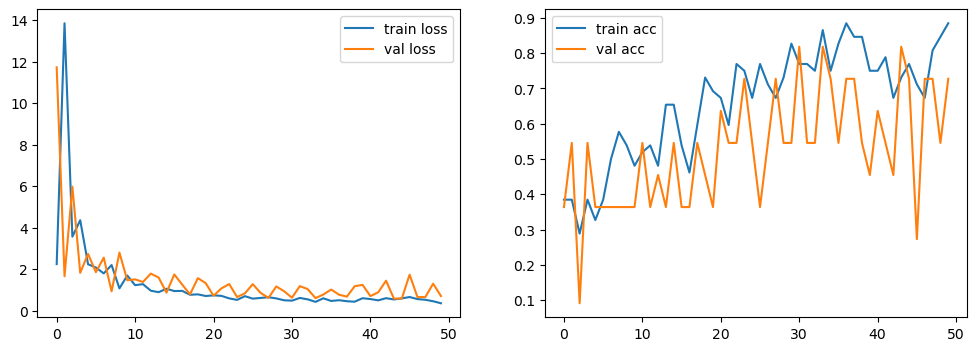

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from glob import glob
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# Enable mixed precision for speed
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Define data paths
train_dir = "dataset/Train"
val_dir = "dataset/Test"

# Get the number of output classes
num_classes = len(glob(train_dir + "/*"))

# Data augmentation
data_augmentation = keras.Sequential([
  preprocessing.Rescaling(1./255),
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.1),
  preprocessing.RandomZoom(0.2),
])

# Load the ResNet50 base model without the top layer
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

# Create the model
model = Sequential([
  data_augmentation,
  base_model,
  Flatten(),
  Dense(num_classes, activation='softmax', dtype='float32'),  # Ensure the output layer dtype is float32
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data loading
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Add this line
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Add this line
)


# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_resnet50.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping_cb, checkpoint_cb],
)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


# Visualizing Training and Validation Loss and Accuracy Over Time

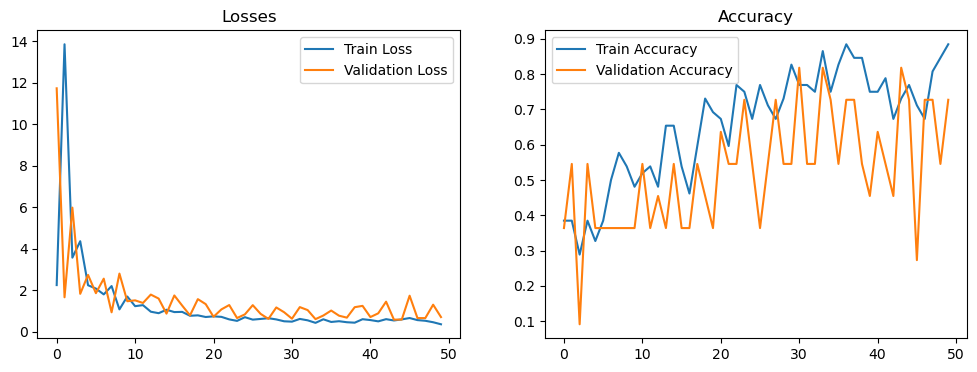

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


# Visualizing Some Training Images

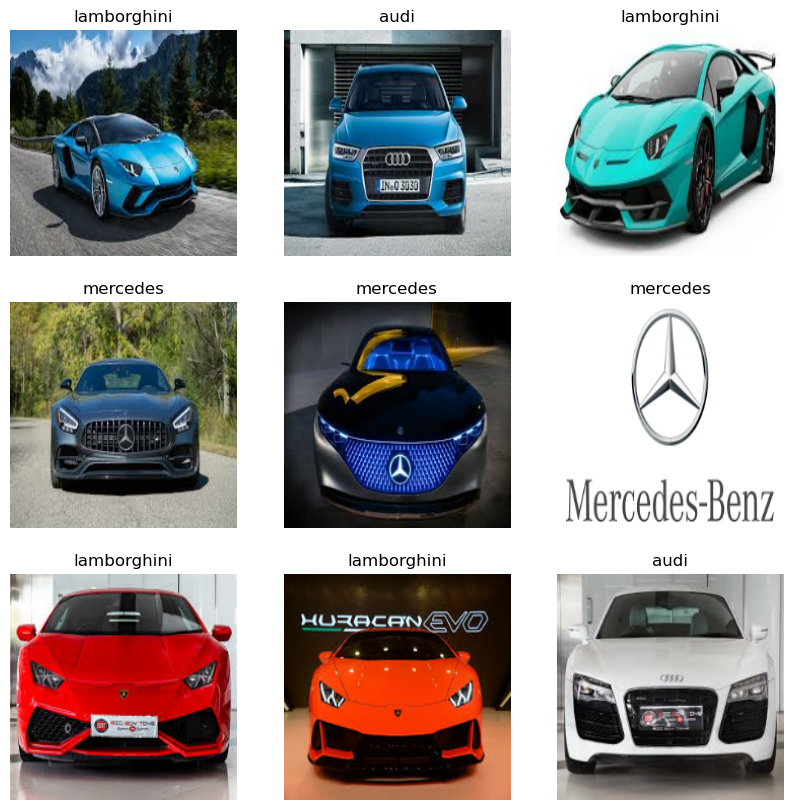

In [12]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = tf.argmax(labels, axis=1) # Add this line
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
model=load_model('model_resnet50.h5')

img=image.load_img('dataset/Test/audi/23.jpg',target_size=(224,224))

x=image.img_to_array(img)

x = x / 255

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

preds = model.predict(img_data)
preds=np.argmax(preds, axis=1)
if preds==1:
  preds="The Car IS Audi"
elif preds==2:
  preds="The Car is Lamborghini"
else:
  preds="The Car Is Mercedes"
print(preds)


1/1 [==============================] - 2s 2s/step
The Car IS Audi
